# Observational study

The goal of the present project is to define a valid metric to evaluate the impact of actors on movies. Specifically, distilling actors careers to a single number, the *star score*. Identifying the latter implies the need to identify truly successful actors, namely actors that had the highest positive impact on movies, in terms of revenues and ratings. Given the presence of multiple confounders, such as the affinity of actors with  particulare genres, different genders or the preference of directors for specific actors, an observational study is carried out to limit the influence of unobserved covariates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re
import warnings
warnings.filterwarnings('ignore')

In [209]:
#importing our clean data
data = pd.read_csv('../data/data.csv', index_col = 0)
data_profit = pd.read_csv('../data/profit_data.csv', index_col = 0)
actors = pd.read_csv('../data/timeScores.csv', index_col = 0)
imdb = pd.read_csv('../data/imdb_budgets.csv', index_col = 0)
ss = pd.read_csv('obs.csv', index_col = 0)

In [213]:
usual_suspects = actors.columns.tolist()[1: -2]

def save_values(df, columns):
    
    for col in columns:
        if (col != 'genres'):
            df[col] = df[col].apply(lambda x : x[1:-1].split(' '))
        else:
            df[col] = df[col].apply(lambda x : x.split("\'")[1::2])
    
    return df

timeScores_fixed = save_values(actors,usual_suspects)

In [215]:
actors['appearances'] = ss['appearances']
actors['gender'] = ss['gender']
actors['revenues'] = ss['rev_sum']
actors['ratings'] = ss['grade_sum']

In [216]:
actors.head(1)

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings,star_score,epfl_score,genres,genre_count,main_genre,2nd_genre,appearances,gender
0,Dustin_Farnum,6117500.0,[1914.],2.861536,[6117500.],[2.86153647],[16.67802278],[2.69731427],"[Black-and-white, Drama, Indie, Silent film, W...","[1, 1, 1, 1, 1]",Black-and-white,Drama,1.0,M


The treatment and control group of the observational study will be identified by the number of times actors starred in movies. The assumption is that successful actors keep acting, while the career of less-successfull ones ends early. This hypothesis is supported by the rich-get-richer mechanism, for which successful actors keep starring with other successful actors, making them even more successful and naturally generating a power law in the appearances distribution.

Just as normal distributions arise from many independent random decisions averaging out, we power laws arise from the feedback introduced by correlated decisions across a population.

Source:
Networks, Crowds, and Markets: Reasoning about a Highly Connected World.
By David Easley and Jon Kleinberg. Cambridge University Press, 2010.
http://www.cs.cornell.edu/home/kleinber/networks-book/

Thedistribution of the number of appearances is shown below. The distribution is a power law because it is represented by a straight line in bi-logarithmic axes (it is linear in the log domain).

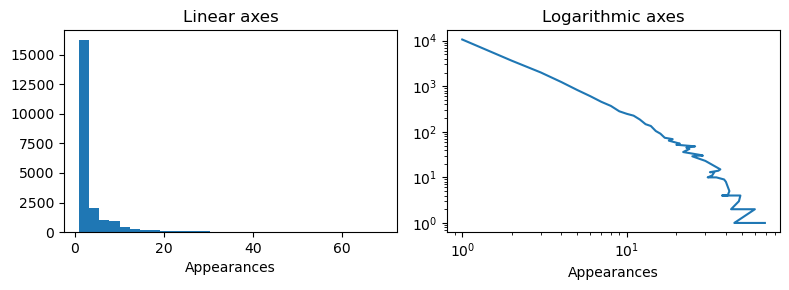

In [217]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

#group by number of appearances and sort
act = actors.groupby('appearances')['appearances'].count().sort_values(ascending=False)

sbplt = ax[0]
sbplt.hist(actors.appearances, bins=30)
sbplt.set_title('Linear axes')
sbplt.set_xlabel('Appearances')

sbplt = ax[1]
sbplt.loglog(act.index,act.values)
sbplt.set_title('Logarithmic axes')
sbplt.set_xlabel('Appearances')
    
fig.tight_layout()
plt.show()

Supported by the previous assumption, the treatment group will be the group with the higher number of appearances. The splitting of the dataset will be carried out based on the median of the distribution, more representative than the mean when considering skewed distributions.

In [218]:
#median
print('The median of the distribution is ' + str(np.median(actors.appearances)))
print('The mean of the distribution is ' + str(np.mean(actors.appearances)))

The median of the distribution is 2.0
The mean of the distribution is 3.588943623426382


To limit the effect of confounders, the individuals of the groups will be matched on propensity score, namely the probability of being in the treatment group based on observed covariates. Given the extremly large size of the dataset, that would require a heavy computational time for the matching, the actors are first clustered into sub-classes, that differ in terms of the parameters chosen to evaluate movie success (revenues and ratings). Eventually, the original dataset is compared to each of the clusters, to extract the most similar one based on the analysis of the statistics and distributions of the parameters of interest.

In [219]:
#standardization of parameters
Xc = actors[{'revenues','ratings'}]
Xc['revenues'] = Xc['revenues'].apply('log')
Xc['ratings'] = Xc['ratings'].apply('log')
Xc['revenues'] = (Xc['revenues'] - Xc['revenues'].mean())/Xc['revenues'].std()
Xc['ratings'] = (Xc['ratings'] - Xc['ratings'].mean())/Xc['ratings'].std()

At first, the optimal number of clusters has to be identified, bearing in mind that we are not looking for distinct sub-classes, but for a method to simplify the large size of the problem, without compromising the outputs of the study.

In [220]:
actors['treatment'] = (actors['appearances'] > 2).astype(int)

To extract the propensity scores, a logistic regression is trained and applied on the same dataset, this will output the needed probabilities.

In is worth mentioning that the revenues and ratings are characteristics that define the success of the movie and that will set the basis for the definition of the *star score*. Therefore, they are not included in the matching features, otherwise they would bias the process of identification of successful actors.

In [221]:
X = actors[{'main_genre','2nd_genre','gender'}]

In [222]:
X = pd.get_dummies(X,columns=['main_genre','2nd_genre','gender'])
y = actors['treatment']

In [223]:
X.head(3)

,main_genre_Absurdism,main_genre_Action,main_genre_Action Comedy,main_genre_Action Thrillers,main_genre_Action/Adventure,main_genre_Addiction Drama,main_genre_Adult,main_genre_Adventure,main_genre_Adventure Comedy,main_genre_Airplanes and airports,...,2nd_genre_Suspense,2nd_genre_Teen,2nd_genre_Thriller,2nd_genre_Time travel,2nd_genre_War film,2nd_genre_Western,2nd_genre_Workplace Comedy,2nd_genre_World cinema,gender_F,gender_M
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [224]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='lbfgs', max_iter=100000)
logistic.fit(X,y)

LogisticRegression(max_iter=100000)

In [225]:
actors['propensity_score'] = [i[0] for i in list(logistic.predict_proba(X))]

To further balance the two sub-groups of actors, the process will only match actors of the same gender. Indeed, the gender is a possible confounder for linking the actors to movie success.

Given the extremely large size of the dataset and the matching exponential time needed to minimize the similarity difference between all the possible combinations, the matching is carried out on randomly chosen subsets of the balanced dataset. The statistical significance of the correlation will depend on the resulting p-value, corrected with the Bonferroni correction.

In [226]:
#function to compute similarity (difference between propensity scores to be minimized in the matching)
def get_similarity(prop1,prop2):
    return 1-abs(prop1-prop2)

In [227]:
import networkx as nx

In [268]:
coefficients = []
for i in range(10):
    ran = actors.sample(frac=.05)

    # Create an empty undirected graph
    G = nx.Graph()

    #define treatment and control groups
    treat = ran[ran['appearances'] > 2]
    contr = ran[ran['appearances'] <= 2]

# Loop through all the pairs of instances
    for i, j in contr.iterrows():
        for k, l in treat.iterrows():
            if j['gender'] == l['gender']:
                # Calculate the similarity 
                similarity = get_similarity(j['propensity_score'],
                                            l['propensity_score'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(i, k, similarity)])
                
                # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)] #create list with all indexes of people paired

    balanced_df = actors.loc[matched] #extract only rows with paired subjects
    
    X1 = balanced_df[{'treatment','revenues','ratings'}]
    X1['revenues'] = X1['revenues'].apply('log')
    #X1['ratings'] = X1['ratings'].apply('log')
    X1['revenues'] = (X1['revenues'] - X1['revenues'].mean())/X1['revenues'].std()
    X1['ratings'] = (X1['ratings'] - X1['ratings'].mean())/X1['ratings'].std()
    
    mod = smf.ols(formula='treatment ~ revenues + ratings',
              data=X1)
    res = mod.fit()
    coeff = res.params.values
    p_values = res.pvalues
    
    coefficients.append({"Int": coeff[0], 'p_int': p_values[0], "C1": coeff[1], 'p1': p_values[1], "C2": coeff[2], 'p2': p_values[2]})

The results of the linear regression on the balanced datasets are shown below. In this case, given the number of randomly chosen samples (10), the Bonferroni correction would be given by:

$\alpha = \frac{\alpha_i}{n} = \frac{0.05}{10} = 0.005$

where $\alpha$ is the overall alpha level, $\alpha_i$ are the alpha levels for each hypothesis and $n$ is the number of hypothesis.

From the results, it it possible to observe that there is alwaya a positive correlation with the revenues and a negative correlation with the ratings. The statistical significance of both correlation is enforced by Bonferroni correction, because of five samples showing statistical significance.

In [270]:
pd.DataFrame(coefficients)

,Int,p_int,C1,p1,C2,p2
0,0.5,3.827165e-122,0.158496,3.196902e-14,-0.052112,0.011128
1,0.5,2.324830e-121,0.184698,4.180626e-19,-0.024554,0.222334
2,0.5,6.291929e-119,0.133337,7.838802e-11,-0.032100,0.112527
3,0.5,4.168961e-125,0.181668,6.356548e-20,-0.074933,0.000115
4,0.5,2.394616e-128,0.164251,1.717207e-17,-0.065031,0.000590
5,0.5,2.878947e-130,0.158259,1.664674e-15,-0.052154,0.007555
6,0.5,3.623435e-131,0.181438,7.131354e-21,-0.060039,0.001477
7,0.5,5.844758e-134,0.180770,9.981054e-21,-0.076043,0.000059
8,0.5,5.192754e-123,0.209407,5.710155e-24,-0.063296,0.001622
9,0.5,7.314468e-126,0.170345,2.073208e-19,-0.040918,0.026451


The *star score* can eventually be defined based on the above analysis.

$star\ score = \tilde{A} + \log{(\\tilde{R} \tilde{G} )}$

where $\tilde{A}$ is the median of the number of appearances in the actors career, $\tilde{R}$, $\tilde{G}$ are the medians of the revenues and ratings caused to the movies he starred in.

As a remainder, male actors were matched together, as well as female actresses, because of the will to tackle the possible confounder of gender disparity. A posteriori, it can be verified that the gender does not play a role in the actor's success on the balanced dataset. Two independent tests are carried out on the balanced dataset (investigating revenues and ratings) and the reslts show p-values larger than 0.05, implying the acceptance of the null-hypothesis that the samples have same averages.

Therefore, the confounder was successfully tackled.

In [82]:
df_m = balanced_df[balanced_df['gender'] == 'M']
df_f = balanced_df[balanced_df['gender'] == 'F']

In [83]:
print(stats.ttest_ind(df_m['revenues'], df_f['revenues'])) #independent test
print(stats.ttest_ind(df_m['ratings'], df_f['ratings'])) #independent test

Ttest_indResult(statistic=1.2557731003167656, pvalue=0.2094005573762068)
Ttest_indResult(statistic=0.5487491385163628, pvalue=0.5832621018055049)
